# 1. Ucitavanje fajlova

In [1]:
import os

# Adresa direktorija u slucaju da radimo na lokalnoj masini
folder_dir = r"C:\Users\Djeneta\OneDrive\Documents\4. god\II semestar\AI\Lab7\audio"

""" 
# Adresa direktorija u slucaju da radimo na Google Colabu
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
folder_dir = "/content/drive/My Drive/audio" 
"""

' \n# Adresa direktorija u slucaju da radimo na Google Colabu\nfrom google.colab import drive\n\ndrive.mount(\'/content/drive\', force_remount=True)\nfolder_dir = "/content/drive/My Drive/audio" \n'

### Broj fajlova u svakom podfolderu

In [2]:
for folder_name in os.listdir(folder_dir):
    folder_path = os.path.join(folder_dir, folder_name)
    if os.path.isdir(folder_path):
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f'{folder_name}: {num_files} fajlova')


bed: 1713 fajlova
bird: 1731 fajlova
cat: 1733 fajlova
dog: 1746 fajlova
down: 2359 fajlova
eight: 2352 fajlova
five: 2357 fajlova
four: 2372 fajlova
go: 2372 fajlova
happy: 1742 fajlova
house: 1750 fajlova
left: 2353 fajlova
marvin: 1746 fajlova
nine: 2364 fajlova
no: 2375 fajlova
off: 2357 fajlova
on: 2367 fajlova
one: 2370 fajlova
right: 2367 fajlova
seven: 2377 fajlova
sheila: 1734 fajlova
six: 2369 fajlova
stop: 2380 fajlova
three: 2356 fajlova
tree: 1733 fajlova
two: 2373 fajlova
up: 2375 fajlova
wow: 1745 fajlova
yes: 2377 fajlova
zero: 2376 fajlova
_background_noise_: 7 fajlova


# 2. Vizualizacija zvucnog signala i spektrograma

In [3]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Funkcija za prikaz talasnog oblika i spektrograma
def plot_waveform_and_specgram(filename: str):
    waveform, sample_rate = torchaudio.load(filename)

    # Resampliranje ako je potrebno
    target_sr = 32_000
    if sample_rate != target_sr:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sr)
        waveform = resampler(waveform)
        sample_rate = target_sr

    # Kreiranje spektrograma
    n_fft = 1024
    hop_length = 512
    spectrogram_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
    spec = spectrogram_transform(waveform)
    spec = T.AmplitudeToDB()(spec.abs())

    # Priprema vremenskih osa
    waveform = waveform[0]  # ako je stereo, uzmi samo prvi kanal
    num_samples = waveform.shape[0]
    duration = num_samples / sample_rate
    time_waveform = torch.linspace(0, duration, steps=num_samples)

    spec_time = torch.linspace(0, duration, steps=spec.shape[-1])
    freqs = torch.linspace(0, sample_rate / 2, steps=spec.shape[-2])

    # Prikaz grafa
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ax1.plot(time_waveform, waveform.numpy(), linewidth=0.8)
    ax1.set_title("Waveform")
    ax1.set_ylabel("Amplituda")

    im = ax2.pcolormesh(spec_time, freqs, spec[0].numpy(), shading='auto', cmap='viridis')
    ax2.set_title("Spektrogram (dB)")
    ax2.set_ylabel("Frekvencija [Hz]")
    ax2.set_xlabel("Vrijeme [s]")

    plt.tight_layout()
    plt.show()

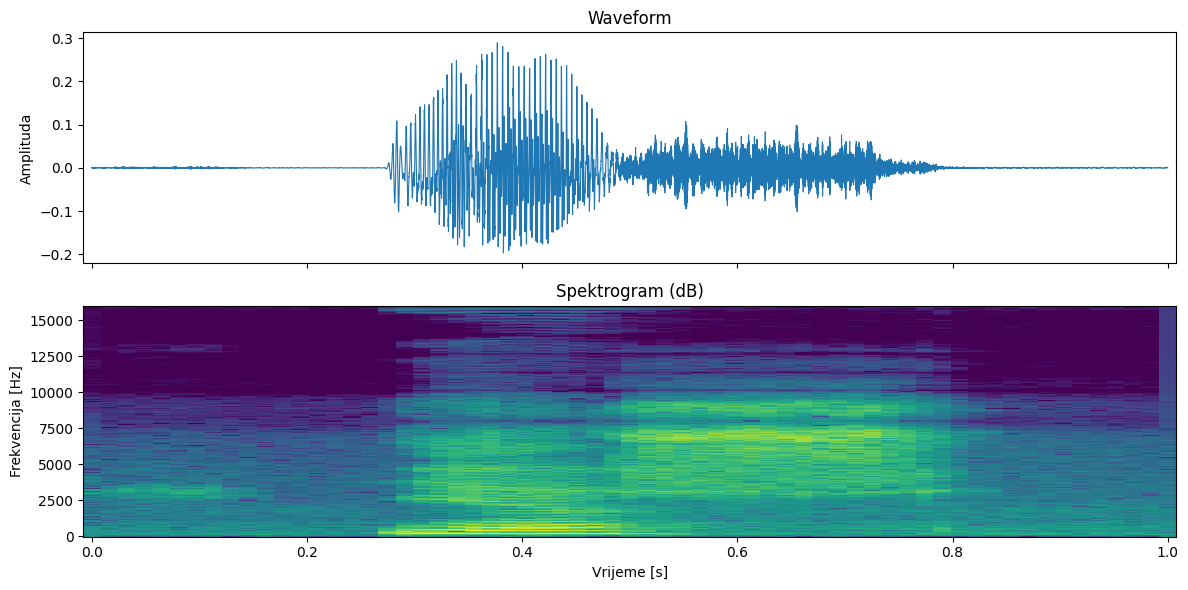

In [4]:
example = folder_dir + '/yes/0a7c2a8d_nohash_0.wav'
plot_waveform_and_specgram(example)

# 3. Kreiranje CSV fajla sa metapodacima

In [5]:
import pandas as pd
import random

output_csv = 'audio_dataset.csv'

class_names = sorted([
    d for d in os.listdir(folder_dir)
    if os.path.isdir(os.path.join(folder_dir, d)) and d != "_background_noise_"
])

class_to_id = {name: idx for idx, name in enumerate(class_names)}

data = []
idx = 0
for class_name in class_names:
    class_id = class_to_id[class_name]
    class_dir = os.path.join(folder_dir, class_name)
    wav_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
    
    selected_files = random.sample(wav_files, max(1, int(len(wav_files))))

    for filename in selected_files:
        file_path = os.path.join(class_name, filename)
        data.append([idx, file_path, class_name, class_id])
        idx += 1

# Cuvanje podataka
df = pd.DataFrame(data, columns=['idx', 'file_path', 'class_name', 'class_id'])
df.to_csv(output_csv, index=False)
print(f'CSV sacuvan kao {output_csv} sa {len(df)} redova.')

CSV sacuvan kao audio_dataset.csv sa 64721 redova.


In [6]:
# Broj uzoraka po klasi
df['class_name'].value_counts()

class_name
stop      2380
seven     2377
yes       2377
zero      2376
no        2375
up        2375
two       2373
go        2372
four      2372
one       2370
six       2369
right     2367
on        2367
nine      2364
down      2359
five      2357
off       2357
three     2356
left      2353
eight     2352
house     1750
marvin    1746
dog       1746
wow       1745
happy     1742
sheila    1734
cat       1733
tree      1733
bird      1731
bed       1713
Name: count, dtype: int64

# 4. Definisanje PyTorch Dataset klase za audio

In [7]:
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch

class AudioDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_path=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.base_path = base_path
        self.sample_rate = 16000
        
        self.log_mel_spectrogram = torch.nn.Sequential(
            T.MelSpectrogram(
                sample_rate=self.sample_rate,
                n_fft=2048,
                hop_length=512,
                n_mels=64
            ),
            T.AmplitudeToDB(stype='power', top_db=80.0)
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.base_path, self.dataframe.loc[idx, 'file_path'])
        label = self.dataframe.loc[idx, 'class_id']

        waveform, sr = torchaudio.load(audio_path)

        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Izračunavanje log-Mel spektrograma
        log_mel_spec = self.log_mel_spectrogram(waveform)

        # Dodavanje dimenzije kanala (potrebno za CNN ulaz)
        log_mel_spec = log_mel_spec.unsqueeze(0)

        log_mel_spec = F.interpolate(log_mel_spec, size=(64, 64), mode='bilinear', align_corners=False)
        log_mel_spec = log_mel_spec.squeeze(0)

        return log_mel_spec, label


# 5. Definisanje CNN modela za klasifikaciju

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# CNN model za klasifikaciju mel-spektrograma audio zapisa
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()

        # Prvi konvolucioni sloj: 1 ulazni kanal, 16 izlaznih, kernel 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Normalizacija za prvi sloj

        # Drugi konvolucioni sloj: 16 -> 32 kanala
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Treci konvolucioni sloj: 32 -> 64 kanala
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Skip veze (1x1 konvolucije za uskladjivanje dimenzija)
        self.skip1 = nn.Conv2d(16, 32, kernel_size=1, stride=1)
        self.skip2 = nn.Conv2d(32, 64, kernel_size=1, stride=1)

        # Maks pooling sloj (2x2)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout nakon konvolucionih slojeva
        self.dropout_conv = nn.Dropout(0.3)

        # Dropout nakon potpuno povezanog sloja
        self.dropout_fc = nn.Dropout(0.5)

        # Prvi potpuno povezani sloj (ulaz: 64 kanala dimenzije 8x8)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.bn_fc = nn.BatchNorm1d(128) 

        # Izlazni sloj: broj klasa
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Prva konvolucija + aktivacija + normalizacija + pooling
        x1 = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Druga konvolucija
        out2 = self.pool(F.relu(self.bn2(self.conv2(x1))))
        # Dodaje skip vezu iz prvog sloja (nakon uskladjivanja dimenzija)
        skip_x1 = self.pool(self.skip1(x1))
        out2 = out2 + skip_x1

        # Treca konvolucija
        out3 = self.pool(F.relu(self.bn3(self.conv3(out2))))
        # Dodaje skip vezu iz drugog sloja
        skip_out2 = self.pool(self.skip2(out2))
        out3 = out3 + skip_out2

        # Primjenjuje dropout nakon konvolucija
        x = self.dropout_conv(out3)

        # Flatten: pretvara tenzor u vektor
        x = x.view(x.size(0), -1)

        # Prvi potpuno povezani sloj + aktivacija
        x = F.relu(self.bn_fc(self.fc1(x)))

        # Dropout
        x = self.dropout_fc(x)

        # Izlazna linearna transformacija (bez aktivacije, koristi se npr. CrossEntropyLoss)
        x = self.fc2(x)

        return x

 # 6. Podjela podataka i treniranje modela

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Dijeljenje skupa podataka na trening i test skup (80/20),
# uz stratifikaciju prema klasama kako bi raspodjela klasa ostala uravnotezena
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class_id'], random_state=42)

# Kreiranje PyTorch dataset objekata za trening i test skup
train_dataset = AudioDataset(train_df, base_path=folder_dir)
test_dataset = AudioDataset(test_df, base_path=folder_dir)

# DataLoader za ucitavanje trening podataka u mini-batchevima, uz mijesanje (shuffle)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# DataLoader za test podatke (bez mijesanja)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Treniranje modela sa Early Stopping-om

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Koristi GPU ako je dostupan, inace koristi CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicijalizacija modela i premjestanje na izabrani uredaj (CPU ili GPU)
model = AudioCNN(num_classes=len(class_names)).to(device)

# Definisanje funkcije gubitka i optimizatora
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Trening parametri
num_epochs = 50
patience = 5  # Zaustavi ako nema poboljsanja tokom 5 epoha
best_val_loss = float('inf')
counter = 0

# Liste za pracenje gubitka i tacnosti kroz epohe
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Trening faza
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_acc = correct_train / total_train

    # Validacija
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    # Cuvanje rezultata za analizu
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f} "
          f"- val_loss: {avg_val_loss:.4f} - val_accuracy: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50 - loss: 1.3128 - accuracy: 0.6302 - val_loss: 0.4504 - val_accuracy: 0.8782
Epoch 2/50 - loss: 0.6262 - accuracy: 0.8111 - val_loss: 0.3694 - val_accuracy: 0.8947
Epoch 3/50 - loss: 0.4974 - accuracy: 0.8491 - val_loss: 0.2776 - val_accuracy: 0.9213
Epoch 4/50 - loss: 0.4323 - accuracy: 0.8674 - val_loss: 0.2897 - val_accuracy: 0.9206
No improvement for 1 epoch(s).
Epoch 5/50 - loss: 0.3901 - accuracy: 0.8807 - val_loss: 0.2438 - val_accuracy: 0.9303
Epoch 6/50 - loss: 0.3618 - accuracy: 0.8882 - val_loss: 0.2239 - val_accuracy: 0.9377
Epoch 7/50 - loss: 0.3321 - accuracy: 0.8972 - val_loss: 0.2197 - val_accuracy: 0.9387
Epoch 8/50 - loss: 0.3191 - accuracy: 0.9015 - val_loss: 0.2066 - val_accuracy: 0.9418
Epoch 9/50 - loss: 0.2985 - accuracy: 0.9064 - val_loss: 0.2120 - val_accuracy: 0.9402
No improvement for 1 epoch(s).
Epoch 10/50 - loss: 0.2849 - accuracy: 0.9107 - val_loss: 0.1883 - val_accuracy: 0.9467
Epoch 11/50 - loss: 0.2714 - accuracy: 0.9145 - val_loss: 0.1936 - 

### Grafici: gubitak i tačnost kroz epohe

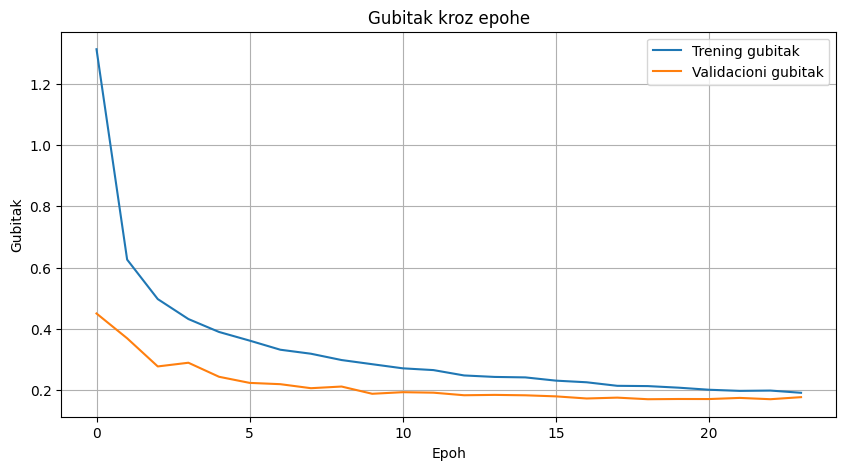

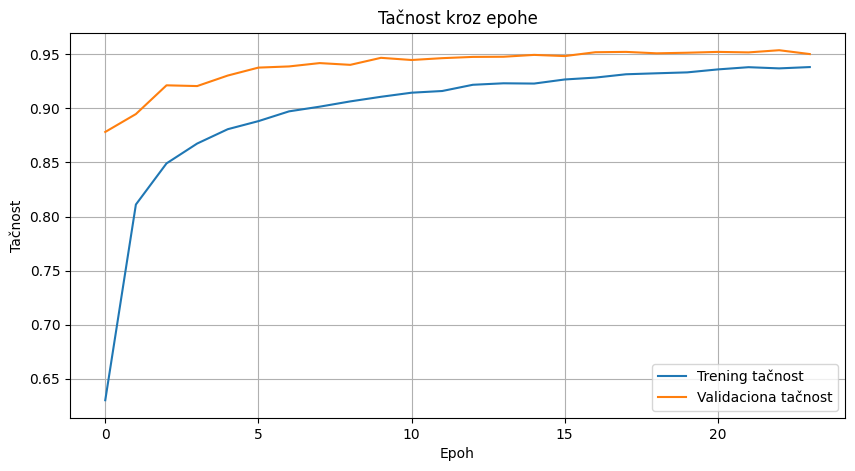

In [11]:
# Gubitak
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Trening gubitak')
plt.plot(val_losses, label='Validacioni gubitak')
plt.xlabel('Epoh')
plt.ylabel('Gubitak')
plt.title('Gubitak kroz epohe')
plt.legend()
plt.grid(True)
plt.show()

# Tačnost
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Trening tačnost')
plt.plot(val_accuracies, label='Validaciona tačnost')
plt.xlabel('Epoh')
plt.ylabel('Tačnost')
plt.title('Tačnost kroz epohe')
plt.legend()
plt.grid(True)
plt.show()

# 7. Evaluacija: Tačnost i matrica konfuzije


Test tacnost: 95.02%


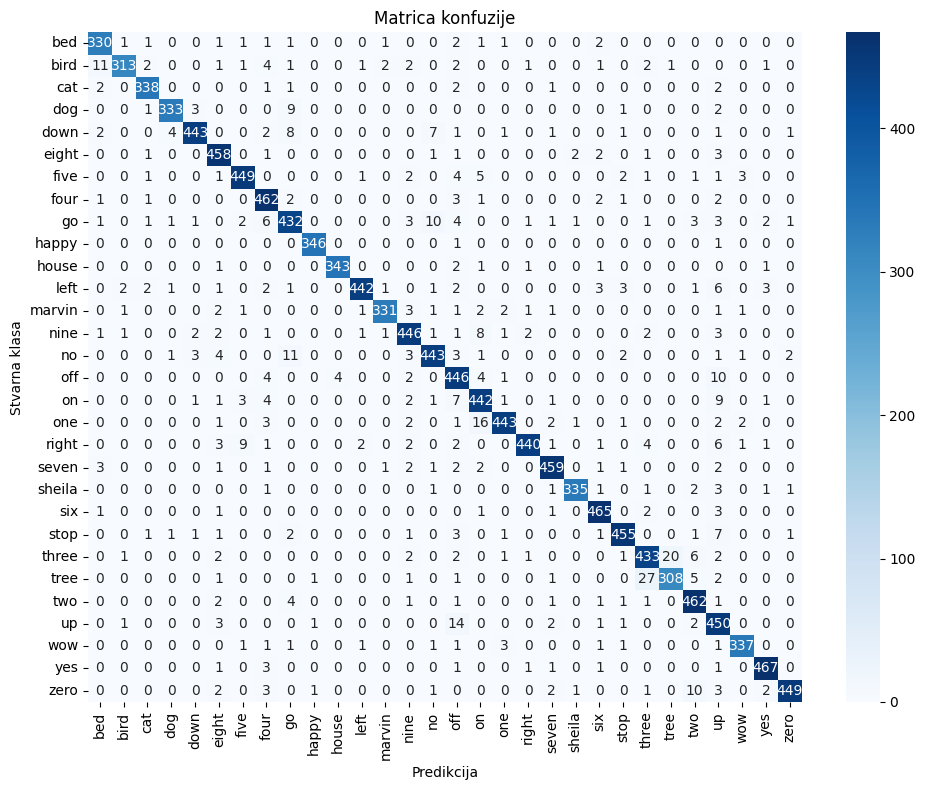

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluacija
model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tačnost
acc = accuracy_score(all_labels, all_preds)
print(f'\nTest tacnost: {acc * 100:.2f}%')

# Matrica konfuzije
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predikcija")
plt.ylabel("Stvarna klasa")
plt.title("Matrica konfuzije")
plt.tight_layout()
plt.show()


# 8. Detaljna evaluacija: F1 skor i klasifikacioni izvještaj

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Postavljanje modela u evaluacijski rezim
model.eval()
all_preds = []    # Lista za sve predikcije
all_labels = []   # Lista za stvarne klase

# Petlja kroz test podatke bez racunanja gradijenata
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # Dobijanje izlaza modela
        _, predicted = torch.max(outputs, 1)  # Izbor najvjerovatnije klase

        all_preds.extend(predicted.cpu().numpy())  # Predikcije na CPU
        all_labels.extend(labels.cpu().numpy())    # Stvarne klase na CPU

# Racunanje F1 score-a (makro i tezinski prosjek)
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("F1 score (macro):", f1_macro)
print("F1 score (weighted):", f1_weighted)

# Prikaz detaljnog klasifikacionog izvjestaja
print("\nKlasifikacioni izvjestaj:")
print(classification_report(all_labels, all_preds))

F1 score (macro): 0.9514218527827533
F1 score (weighted): 0.9503656882135068

Klasifikacioni izvjestaj:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       343
           1       0.98      0.90      0.94       346
           2       0.97      0.97      0.97       347
           3       0.98      0.95      0.97       349
           4       0.98      0.94      0.96       472
           5       0.93      0.97      0.95       470
           6       0.96      0.95      0.96       471
           7       0.92      0.97      0.95       475
           8       0.91      0.91      0.91       474
           9       0.99      0.99      0.99       348
          10       0.99      0.98      0.98       350
          11       0.98      0.94      0.96       471
          12       0.98      0.95      0.97       349
          13       0.94      0.94      0.94       473
          14       0.94      0.93      0.94       475
          15       0.87      0.

In [71]:
import sounddevice as sd
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
from typing import List, Optional
import librosa
import os

# Odabir uređaja (GPU ako je dostupan, inače CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Snimanje zvuka ---
def record_audio(duration: float = 5.0, sample_rate: int = 16000) -> Optional[torch.Tensor]:
    """Snimanje zvuka sa mikrofona i normalizacija."""
    print(f"Snimam {duration} sekundi... Govorite sada.")
    try:
        audio = sd.rec(int(duration * sample_rate),
                       samplerate=sample_rate,
                       channels=1,
                       dtype='float32')
        sd.wait()
        print("Snimanje završeno.")
        audio_tensor = torch.from_numpy(audio.T).float()
        audio_tensor /= torch.max(torch.abs(audio_tensor)) + 1e-9  # normalizacija
        return audio_tensor
    except Exception as e:
        print(f"Greška pri snimanju zvuka: {e}")
        return None

def predict_words_by_segments(
    model: torch.nn.Module,
    waveform: torch.Tensor,
    sample_rate: int = 16000,
    energy_threshold: float = 0.02,
    min_word_duration: float = 0.25,
    min_silence_duration: float = 0.05,
    confidence_threshold: float = 0.7
) -> List[str]:
    """
    Prepoznavanje riječi koristeći segmentaciju na osnovu energije.

    Argumenti:
    - model: istrenirani PyTorch model
    - waveform: 1D tensor sa audio signalom
    - sample_rate: frekvencija uzorkovanja
    - energy_threshold: prag RMS energije za otkrivanje govora
    - min_word_duration: minimalno trajanje riječi u sekundama
    - min_silence_duration: minimalno trajanje tišine između riječi
    - confidence_threshold: prag pouzdanosti za prepoznavanje UNKNOWN

    Povratna vrijednost:
    - Lista prepoznatih riječi
    """
    if waveform is None or waveform.numel() == 0:
        return []

    device = next(model.parameters()).device
    waveform = waveform.squeeze().to(device)
    audio_np = waveform.cpu().numpy()

    # Izračun RMS energije
    frame_length = int(0.025 * sample_rate)
    hop_length = int(0.01 * sample_rate)
    energy = librosa.feature.rms(y=audio_np, frame_length=frame_length, hop_length=hop_length).squeeze()

    # Detekcija govornih frejmova
    speech_frames = energy > energy_threshold
    segments = []
    start_frame = None

    for i, is_speech in enumerate(speech_frames):
        if is_speech and start_frame is None:
            start_frame = i
        elif not is_speech and start_frame is not None:
            end_frame = i
            start_sample = int(start_frame * hop_length)
            end_sample = int(min(end_frame * hop_length + frame_length, len(audio_np)))
            duration = (end_sample - start_sample) / sample_rate
            if duration >= min_word_duration:
                segments.append((start_sample, end_sample))
            start_frame = None

    # Ako je ostao posljednji segment
    if start_frame is not None:
        start_sample = int(start_frame * hop_length)
        end_sample = len(audio_np)
        duration = (end_sample - start_sample) / sample_rate
        if duration >= min_word_duration:
            segments.append((start_sample, end_sample))

    # Mel spektrogram
    mel_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=64,
        power=2
    ).to(device)

    predicted_words = []

    for start, end in segments:
        segment = waveform[start:end]
        if segment.abs().mean() < 1e-4:
            continue

        spec = mel_transform(segment.unsqueeze(0))
        spec = T.AmplitudeToDB(stype='power', top_db=80)(spec)
        spec = F.interpolate(spec.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False)

        with torch.no_grad():
            outputs = model(spec)
            probs = F.softmax(outputs, dim=1)
            max_prob, predicted = torch.max(probs, dim=1)
            if max_prob.item() < confidence_threshold:
                predicted_words.append("UNKNOWN")
            else:
                predicted_words.append(class_names[predicted.item()])

    return predicted_words


# --- Primjer korištenja ---
if __name__ == "__main__":
    if model is None:
        output_csv = 'audio_dataset.csv'
        class_names = sorted([
            d for d in os.listdir(folder_dir)
            if os.path.isdir(os.path.join(folder_dir, d)) and d != "_background_noise_"
        ])
        model = AudioCNN(num_classes=len(class_names))
        model.load_state_dict(torch.load("best_model.pth", map_location=device))
        model.to(device)
        model.eval()

    waveform = record_audio(duration=10)
    if waveform is not None:
        words = predict_words_by_segments(model, waveform)
        if words:
            print("Prepoznate riječi:", " ".join(words))
        else:
            print("Nijedna riječ nije detektovana")
    else:
        print("Greška: nije moguće snimiti audio")


Snimam 10 sekundi... Govorite sada.
Snimanje završeno.
Prepoznate riječi: two UNKNOWN UNKNOWN three one UNKNOWN
